In [1]:
# unit test
import unittest

import glob

import torch
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp


import sys
sys.path.insert(0, r"../helper")
print(sys.path)

# relevant: import the UncertaintyMetric
from compute.metric.uncertainty import * 

from dataset.meanteacher import *


['../helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\examples', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


ModuleNotFoundError: No module named 'dataset'

In [2]:
class UnitTestUncertainty(unittest.TestCase):   

        
    def test_metric(self):
        
        # preparation
        channels = 1
        n_output_neurons=2
        model = smp.UnetPlusPlus(
                                encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                                encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
                                in_channels=channels,          # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                                classes=n_output_neurons,         # model output channels (number of classes in your dataset)
                            )
        csv_filenames = glob.glob(r"../data_prep/mt_*.csv")
        # image size has to be dividable by 32!!
        dataset = MeanTeacherTrainDataset(mode="train", channels=channels, image_size=512, csv_filenames=csv_filenames)
        train_loader = DataLoader(dataset, batch_size=3, shuffle=False)

        # relevant: create instance of class
        um = UncertaintyMetric(n_noise=4, n_repeat=2, n_output_neurons=n_output_neurons)
        uncertainy_mask = None

        # load one batch
        for idx, item in enumerate(train_loader):

            # relevant: get mask
            uncertainy_mask = um.run(model, item["img"])
            print(uncertainy_mask)

            plt.figure()
            plt.imshow( uncertainy_mask[0].permute(1, 2, 0), cmap="gray" )

            plt.figure()
            plt.imshow( uncertainy_mask[0].permute(1, 2, 0) < 0.68, cmap="gray" )

            break

    
    
    def test_dummy(self):
        
        # same code as in metric class, but with prints
        
        import torch

        #for image in batch:

        batch_size = 6
        width = 3
        height = 3
        n_copy = 2
        n_noise = 4
        output_neurons = 5
        input_channels = 1

        tmp_img = torch.rand(batch_size, input_channels, width, height) # 1 image, 2 probability outputs, 3x3 wxh
        print("action: dummy batch")
        print("batch shape", tmp_img.shape, "### batch size, input_channels, w, h")
        print()

        tmp_img_double = tmp_img.repeat(n_copy, 1, 1 ,1) # becomes 6, 2, 3, 3
        print("action: repeat dummy batch")
        print("batch shape double", tmp_img_double.shape, "### batch size * 2, input_channels, w, h")
        print()

        batch_times_repeat = tmp_img_double.shape[0] # = 6

        preds = torch.zeros( (batch_size*n_noise*n_copy), output_neurons, width, height )
        print("action: tensor for predictions")
        print("shape", preds.shape, "### n_noise * batch_size * 2 , output_neurons, w, h")
        print()

        for i in range (n_noise):

            noise = torch.clamp(torch.randn_like(tmp_img_double) * 0.1, min=-0.2, max=0.2)

            ema_input = tmp_img_double + noise

            with torch.no_grad():
                #print(n_copy * batch_size * i)
                #print(n_copy * batch_size * (i+1))
                preds[n_copy * batch_size * i    :    n_copy * batch_size * (i+1)] = i # model(input)

        preds = torch.nn.functional.softmax(preds, dim=1)


        preds = preds.reshape(n_copy*n_noise, batch_size, output_neurons, width, height)
        print("action: reshape")
        print("shape", preds.shape, " ### noise*2, batch size, output neuronns, w, h")
        print()

        preds = torch.mean(preds, dim=0)
        print("action: mean on dimension 0")
        print("shape", preds.shape, " ### batch size, output neuronns, w, h")
        print()

        uncertainty = -torch.sum(preds * torch.log(preds), dim=1, keepdim=True)
        print("action: uncertainty on dimension 1")
        print("uncertainty shape", uncertainty.shape, " ### batch size, 1, w, h")
        print()




In [3]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.

action: dummy batch
batch shape torch.Size([6, 1, 3, 3]) ### batch size, input_channels, w, h

action: repeat dummy batch
batch shape double torch.Size([12, 1, 3, 3]) ### batch size * 2, input_channels, w, h

action: tensor for predictions
shape torch.Size([48, 5, 3, 3]) ### n_noise * batch_size * 2 , output_neurons, w, h

action: reshape
shape torch.Size([8, 6, 5, 3, 3])  ### noise*2, batch size, output neuronns, w, h

action: mean on dimension 0
shape torch.Size([6, 5, 3, 3])  ### batch size, output neuronns, w, h

action: uncertainty on dimension 1
uncertainty shape torch.Size([6, 1, 3, 3])  ### batch size, 1, w, h



E
ERROR: test_metric (__main__.UnitTestUncertainty)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Prinzessin\AppData\Local\Temp\ipykernel_18664\1160094553.py", line 31, in test_metric
    plt.figure()
NameError: name 'plt' is not defined

----------------------------------------------------------------------
Ran 2 tests in 123.785s

FAILED (errors=1)


tensor([[[[0.6539, 0.6871, 0.6093,  ..., 0.6188, 0.6931, 0.6763],
          [0.6470, 0.5947, 0.5041,  ..., 0.4452, 0.5036, 0.6048],
          [0.6251, 0.6854, 0.5554,  ..., 0.5942, 0.6410, 0.5817],
          ...,
          [0.6923, 0.6742, 0.6931,  ..., 0.6849, 0.6289, 0.5847],
          [0.5452, 0.6760, 0.6906,  ..., 0.5764, 0.4018, 0.3620],
          [0.5624, 0.6746, 0.6780,  ..., 0.6094, 0.6683, 0.5042]]],


        [[[0.6498, 0.6918, 0.6255,  ..., 0.5922, 0.6930, 0.6882],
          [0.6851, 0.6618, 0.6026,  ..., 0.4693, 0.4991, 0.5838],
          [0.6745, 0.6906, 0.6815,  ..., 0.5886, 0.6730, 0.5786],
          ...,
          [0.6911, 0.6521, 0.6816,  ..., 0.6091, 0.5632, 0.5756],
          [0.5697, 0.6675, 0.6926,  ..., 0.6106, 0.5296, 0.4049],
          [0.6418, 0.6809, 0.6630,  ..., 0.5275, 0.6912, 0.4833]]],


        [[[0.6119, 0.6922, 0.6509,  ..., 0.6734, 0.6901, 0.6841],
          [0.6548, 0.5971, 0.5724,  ..., 0.5675, 0.4399, 0.6045],
          [0.6897, 0.6879, 0.6780,  ..

# Confusion Matrix

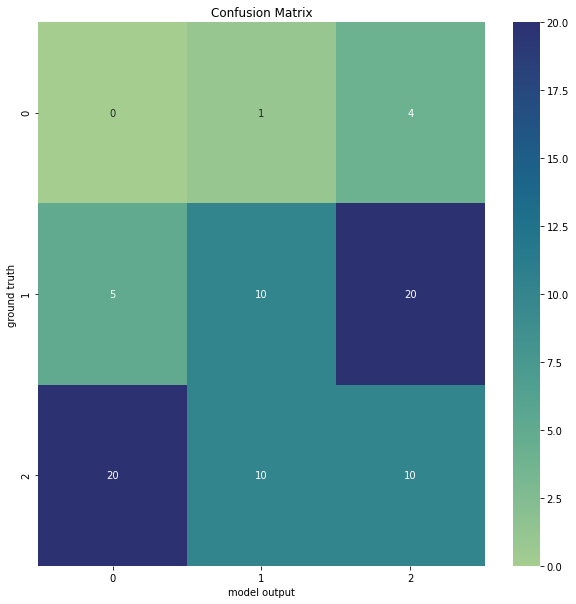

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 

confusion_matrix_computed = [[0, 1, 4], [5, 10, 20], [20, 10, 10]]

df_cm = pd.DataFrame(confusion_matrix_computed)
plt.figure(figsize = (10,10))


cm_fig = sns.heatmap(df_cm, annot=True, cmap='crest') # .get_figure() # '.2%'

plt.xlabel("model output")
plt.ylabel("ground truth")
plt.title("Confusion Matrix")

cm_fig.figure.savefig(f"example_results/cm_epoch_{5}.png")

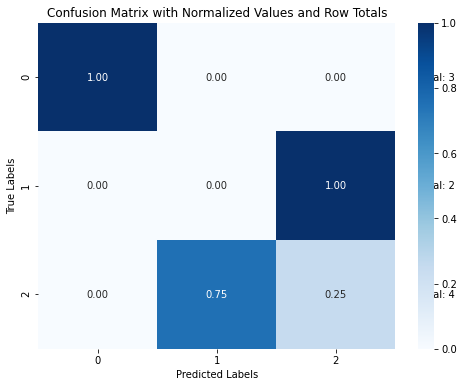

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate some example data
y_true = np.array([0, 1, 2, 0, 1, 2, 0, 2, 2])
y_pred = np.array([0, 2, 1, 0, 2, 1, 0, 2, 1])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate normalized values for each row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure
plt.figure(figsize=(8, 6))

# Create a confusion matrix heatmap with normalized values
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')

# Add row sums to the right of the confusion matrix
for i in range(len(cm)):
    row_sum = sum(cm[i])
    plt.text(len(cm) + 0.2, i + 0.5, f"Total: {row_sum}", va='center')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Normalized Values and Row Totals')
plt.show()

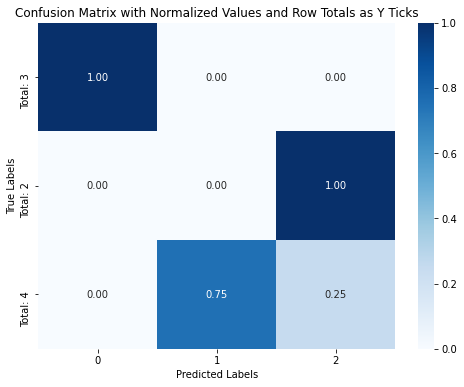

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate some example data
y_true = np.array([0, 1, 2, 0, 1, 2, 0, 2, 2])
y_pred = np.array([0, 2, 1, 0, 2, 1, 0, 2, 1])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate normalized values for each row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure
plt.figure(figsize=(8, 6))

# Create a confusion matrix heatmap with normalized values
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')

# Get the row sums and add them to the y tick labels
row_sums = cm.sum(axis=1)
plt.yticks(np.arange(len(row_sums)) + 0.5, [f'Total: {row_sum}' for row_sum in row_sums])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Normalized Values and Row Totals as Y Ticks')
plt.show()

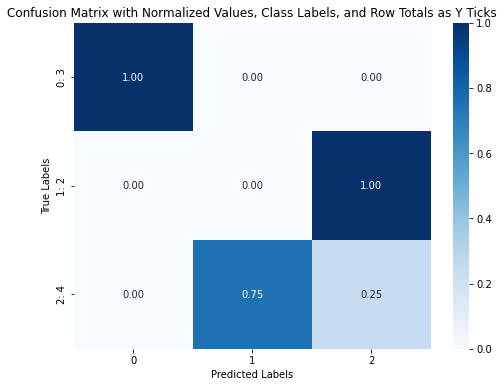

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate some example data
y_true = np.array([0, 1, 2, 0, 1, 2, 0, 2, 2])
y_pred = np.array([0, 2, 1, 0, 2, 1, 0, 2, 1])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate normalized values for each row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure
plt.figure(figsize=(8, 6))

# Create a confusion matrix heatmap with normalized values
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')

# Get the class labels and row sums
class_labels = ['0', '1', '2']
row_sums = cm.sum(axis=1)

# Create y tick labels with both class labels and row sums
y_ticks = [f'{class_labels[i]}: {row_sums[i]}' for i in range(len(class_labels))]
plt.yticks(np.arange(len(class_labels)) + 0.5, y_ticks, va='center')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Normalized Values, Class Labels, and Row Totals as Y Ticks')
plt.show()

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

from cmatrix import plot_class_accuracies

iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
classifier = svm.SVC(kernel='linear', C=0.01).fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2)

disp = plot_confusion_matrix(classifier, X_test, y_test,
                             display_labels=class_names,
                             ax=ax1,
                             cmap=plt.cm.Blues)

plot_class_accuracies(disp, ax2, display_labels=class_names, cmap=plt.cm.Blues)

plt.show()

ModuleNotFoundError: No module named 'cmatrix'

[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
       0      1      2    3    4    5    6    7    8    9   10   11   12   13  \
0   50.0   50.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  100.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

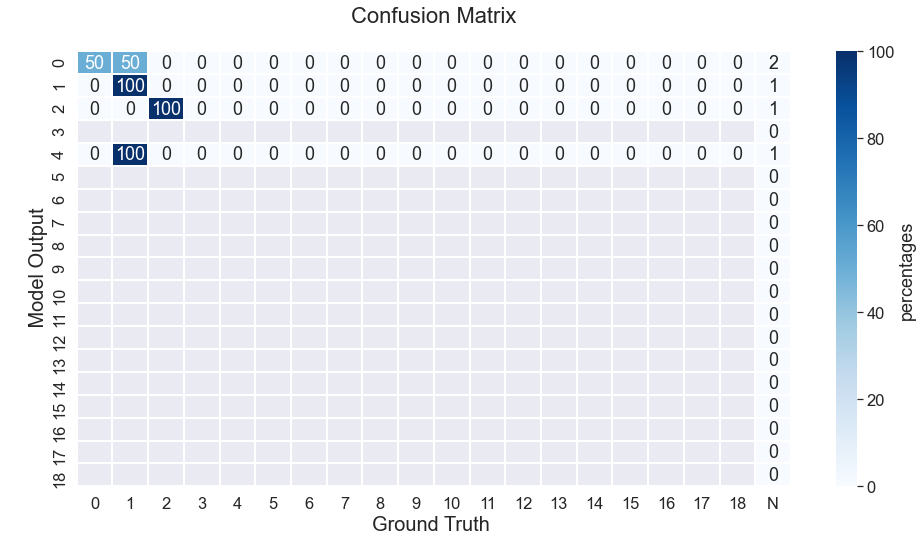

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchmetrics import ConfusionMatrix
import torchmetrics

cf_matrix = np.array([[50, 2, 38],
                      [7, 43, 32],
                      [1,  0, 4]])

epoch_ground_truth = torch.tensor([2, 1, 0, 0, 4])
epoch_model_output = torch.tensor([2, 1, 0, 1, 1])

confusion_matrix = torchmetrics.ConfusionMatrix(task = 'multiclass', num_classes=19)
confusion_matrix(epoch_model_output, epoch_ground_truth.int())

cf_matrix = confusion_matrix.compute().detach().cpu().numpy().astype(int)


print(cf_matrix)
#tensor([[1, 1, 0],
#        [0, 1, 0],
#        [0, 0, 1]])

#labels = ['col1','col2','col3']
labels = np.arange(0,19)
df_confusion = pd.DataFrame(cf_matrix, index = labels, columns=labels)
# cm_normalized = df_confusion.astype('float') / df_confusion.sum(axis=1)[:, np.newaxis]

df_confusion_total = df_confusion.sum(axis=1)

cm_normalized = df_confusion.div(df_confusion_total, axis=0) * 100
cm_normalized['N'] = df_confusion.sum(axis=1)

#cm_normalized['TOTAL'] = cm_normalized.sum(axis=1)
# df_confusion.loc['TOTAL'] = df_confusion.sum()

# get percentages
df_percentages = df_confusion.div(df_confusion_total, axis=0) * 100
df_percentages["N"] = 0


# df_percentages.loc['TOTAL'] = 0

print(df_percentages)
print(cm_normalized)


# print(df_confusion)

#cm_normalized.TOTAL = 0
#print(cm_normalized)

# =============================================================================
#            col1      col2      col3  TOTAL
# col1   0.555556  0.022222  0.422222      0
# col2   0.085366  0.524390  0.390244      0
# col3   0.200000  0.000000  0.800000      0
# =============================================================================

plt.figure(figsize=(16, 8))
                        
sns.set(font_scale = 1.5)

# fmt="d", 

# cmap using data for color, taking values from annot
ax = sns.heatmap(data=df_percentages, annot=cm_normalized, cmap='Blues', vmin=0, vmax=100, fmt=".0f", linewidths=2,
                 cbar_kws={'label': 'percentages'})  
  
ax.set_title('Confusion Matrix\n',size=22)
ax.set_ylabel('\n Model Output',size=20)
ax.set_xlabel('Ground Truth ', size=20)

plt.show()

## cm_fig.figure.savefig(f"results/cm_epoch{self.current_epoch}.png")
ax.figure.savefig(f"example_results/cm_epoch_{5}.png")

<AxesSubplot:>

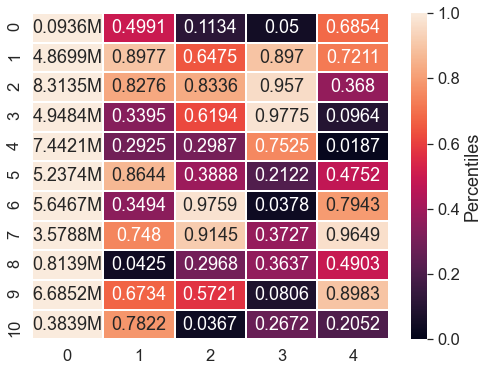

In [153]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# sample data
np.random.seed(2022)
data = np.random.random(size=(11, 5))
data[:, 0] = data[:, 0] * 10_000_000

# sample dataframe
df = pd.DataFrame(data)

# create a dataframe to use for annotations
annot = df.copy()

# format the desired column; 0 here is the name of the column
annot[0] = annot[0].div(1000000).round(4).astype(str) + 'M'

# format the rest of the numbers in the dataframe
annot = annot.round(4)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=df, annot=annot, fmt='', vmin=0, vmax=1, linewidths=2,
            cbar_kws={'label': 'Percentiles', 'orientation': 'vertical'}, ax=ax)